In [2]:
import pandas as pd
import numpy as np
from math import ceil
import nltk 
import copy
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict

In [3]:
%ls

data/                           how_to_generate_features.ipynb
deep_learning.ipynb             how_to_tune_models.ipynb


In [4]:
raw_train = pd.read_csv('data/titanic_dataset_raw_train.csv')
raw_test = pd.read_csv('data/titanic_dataset_raw_test.csv')


raw_train.columns = list(map(lambda x: x.lower(), raw_train.columns))
raw_test.columns = list(map(lambda x: x.lower(), raw_test.columns))
target = 'survived'

# Preprocessing features

In [343]:
features_types = dict(raw_train.dtypes)

features_types_mapping = defaultdict(list)
for k, v in features_types.items():
    features_types_mapping[v.name].append(k)

In [344]:
features_types_mapping

defaultdict(list,
            {'int64': ['passengerid', 'survived', 'pclass', 'sibsp', 'parch'],
             'object': ['name', 'sex', 'ticket', 'cabin', 'embarked'],
             'float64': ['age', 'fare']})

In [409]:
def plot_features_dist(df, features_cols, plots_per_row=3, substitue_nan_vals=0):
    plot_rows = ceil(len(features_cols) / plots_per_row)
    
    fig = plt.figure(figsize=(16, 5*plot_rows))
    for i, col in enumerate(features_cols, 1):
        ax = fig.add_subplot(plot_rows, plots_per_row, i)
        if col == target:
            color_plot = 'red'
        else:
            color_plot = 'blue'
        sns.distplot(df[col].fillna(substitue_nan_vals), color=color_plot)
        
    plt.tight_layout()
    plt.show()

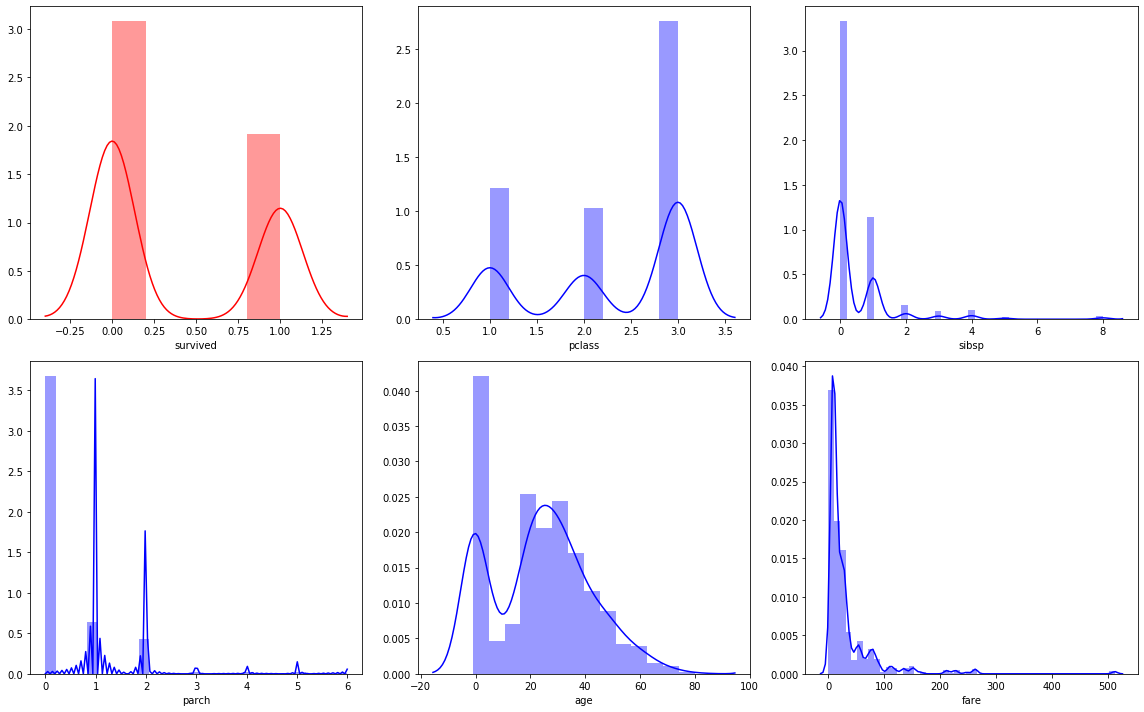

In [307]:
num_cols = features_types_mapping.get('int64') + features_types_mapping.get('float64')
num_cols = list(filter(lambda x: 'id' not in x.lower(), num_cols))
plot_features_dist(raw_train, num_cols)

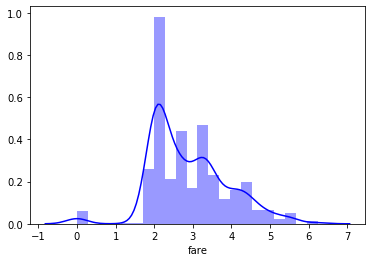

In [308]:
sns.distplot(raw_train['fare'].apply(lambda x: np.log(x) if x else 0), color='blue')

In [345]:
raw_train['fare'] = raw_train['fare'].apply(lambda x: np.log(x) if x else 0)
raw_test['fare'] = raw_test['fare'].apply(lambda x: np.log(x) if x else 0)

## Categorical features

In [346]:
features_types_mapping.get('object')

['name', 'sex', 'ticket', 'cabin', 'embarked']

In [347]:
def get_list_uniq_feat_vals(df, feature_name, exclude_nans=True):
    uniq_feat_vals = list(df[feature_name].unique())
    if exclude_nans:
        uniq_feat_vals = list(filter(lambda x: x is not None and not pd.isnull(x), uniq_feat_vals))
    return uniq_feat_vals

def encode_cat_feats_with_num(raw_train, raw_test, features):
    df_train = copy.deepcopy(raw_train)
    df_test = copy.deepcopy(raw_test)
    for feature_name in features:
        # get unique feature values excluding NaN values
        uniq_feat_vals_train = get_list_uniq_feat_vals(df_train, feature_name)
        uniq_feat_vals_test = get_list_uniq_feat_vals(df_test, feature_name)
        
        # if test has new categories
        if not set(uniq_feat_vals_test).issubset(uniq_feat_vals_train):
            feature_encoding = {val: i for i, val in enumerate(uniq_feat_vals_test)}
        else:
            feature_encoding = {val: i for i, val in enumerate(uniq_feat_vals_train)}
            
        # apply new encoding
        df_train[feature_name] = df_train[feature_name].apply(lambda x: feature_encoding.get(x))
        df_test[feature_name] = df_test[feature_name].apply(lambda x: feature_encoding.get(x))
    return df_train, df_test

In [348]:
train, test = encode_cat_feats_with_num(raw_train, raw_test, ['sex', 'embarked'])

## Text analysis

In [349]:
def clean_tokenize_str(str_val):
    clean_str = re.sub(r'[^\w\s]', '', str(str_val).lower().strip())
    # tokenize string 
    return clean_str.split()

def remove_stop_words(str_val):
    # str_val is tokenized and cleaned for removal of stop words
    stop_words = nltk.corpus.stopwords.words("english")
    str_without_stopwords = list(reduce(lambda x: x not in stop_words), str_val)
    return str_without_stopwords

stemmer = nltk.stem.porter.PorterStemmer()
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def str_stemming(str_val):
    # faster than lemming, may include not existing words
    return [stemmer.stem(word) for word in str_val]

def str_lemming(str_val):    
    return [lemmatizer.lematize(word) for word in str_val]

In [350]:
train['name'] = train['name'].apply(lambda x: clean_tokenize_str(x))
test['name'] = test['name'].apply(lambda x: clean_tokenize_str(x))

In [351]:
feature = 'name'
for prefix in ['mr', 'mrs', 'miss']:
    train[f'{feature}_has_{prefix}'] = train[feature].apply(lambda x: prefix in x).astype(int)
    test[f'{feature}_has_{prefix}'] = test[feature].apply(lambda x: prefix in x).astype(int)

In [352]:
def get_text_length_feats(df, features_list):
    # TO-DO: check if tokenized
    for feature in features_list:
        df[f'{feature}_word_count'] = df[feature].apply(lambda x: 0 if not x else len(x))
        df[f'{feature}_char_count'] = df[feature].apply(lambda x: 0 if not x
                                                        else sum(len(word) for word in str(x).split(" ")))
        df[f'{feature}_avg_word_length'] = df[f'{feature}_char_count'] / df[f'{feature}_word_count']
        df[f'{feature}_avg_word_length'].fillna(0, inplace=True)
    return df

In [353]:
train['cabin'] = train['cabin'].apply(lambda x: '' if pd.isnull(x) else x)
test['cabin'] = test['cabin'].apply(lambda x: '' if pd.isnull(x) else x)

train = get_text_length_feats(train, ['name', 'cabin'])
test = get_text_length_feats(test, ['name', 'cabin'])

In [356]:
train['cabin'] = train['cabin'].apply(lambda x: '' if not x or pd.isnull(x) 
                                      else ''.join(char for char in x if char.isalpha())
                                     ).apply(lambda x: None if not x else list(set(x))[0])
test['cabin'] = test['cabin'].apply(lambda x: '' if not x or pd.isnull(x) 
                                      else ''.join(char for char in x if char.isalpha())
                                     ).apply(lambda x: None if not x else list(set(x))[0])

train, test = encode_cat_feats_with_num(train, test, ['cabin'])

In [376]:
top_letters_ticket = train['ticket'].apply(lambda x: '' if not x or pd.isnull(x)
                                           else ''.join(char for char in x if char.isalpha())
                                          ).value_counts().head(4).index
top_letters_ticket = [val for val in top_letters_ticket if val]

feature = 'ticket'
for top_letters_set in top_letters_ticket:
    train[f'{feature}_has_{top_letters_set}'] = train[feature].apply(lambda x: top_letters_set in x).astype(int)
    test[f'{feature}_has_{top_letters_set}'] = test[feature].apply(lambda x: top_letters_set in x).astype(int)

## Missing values

## First feature list

In [ ]:
extended_feature_list = [col for col in train.columns if 'id' not in col ]

In [392]:
train_col_to_type_mapping = {col:col_type.name for col, col_type in dict(train.dtypes).items()}
extended_feature_list = list(dict(filter(lambda x: x[1] != 'object' 
                                    and 'id' not in x[0] 
                                    and x[0] != target, train_col_to_type_mapping.items())).keys())

In [393]:
extended_feature_list

['pclass',
 'sex',
 'age',
 'sibsp',
 'parch',
 'fare',
 'cabin',
 'embarked',
 'name_has_mr',
 'name_has_mrs',
 'name_has_miss',
 'name_word_count',
 'name_char_count',
 'name_avg_word_length',
 'cabin_word_count',
 'cabin_char_count',
 'cabin_avg_word_length',
 'ticket_has_PC',
 'ticket_has_CA',
 'ticket_has_A']

In [395]:
train[extended_feature_list].shape, test[extended_feature_list].shape

((891, 20), (418, 20))

In [407]:
def get_cols_with_missing_values(df, columns_list):
    return list(filter(lambda x: df[x].isnull().values.any(), columns_list))

In [410]:
cols_with_missing = get_cols_with_missing_values(train, extended_feature_list)

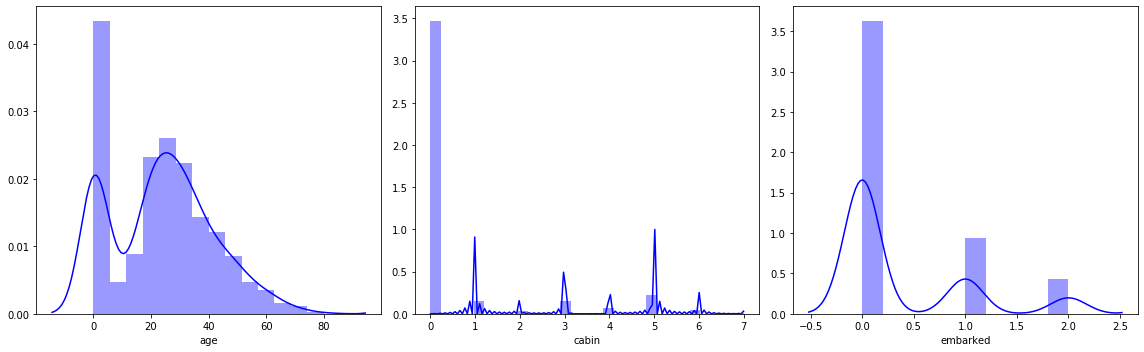

In [411]:
plot_features_dist(train, cols_with_missing, substitue_nan_vals=0)

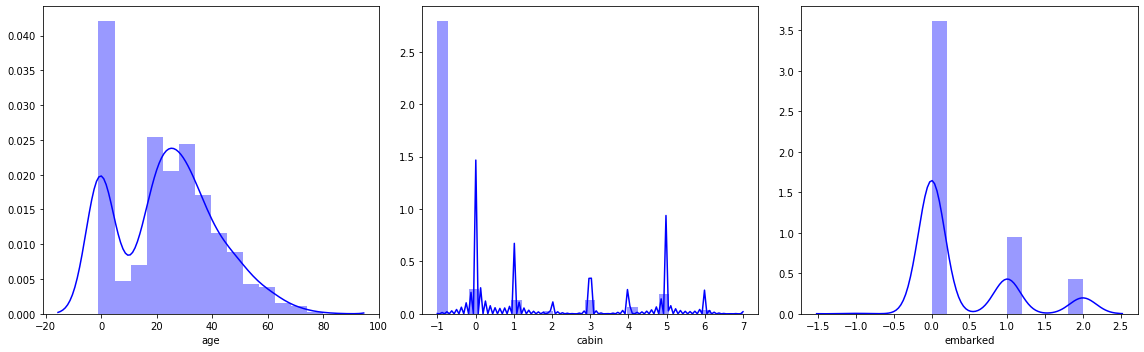

In [412]:
plot_features_dist(train, cols_with_missing, substitue_nan_vals=-1)

In [413]:
for col in cols_with_missing:
    train[col].fillna(0, inplace=True)
    test[col].fillna(0, inplace=True)

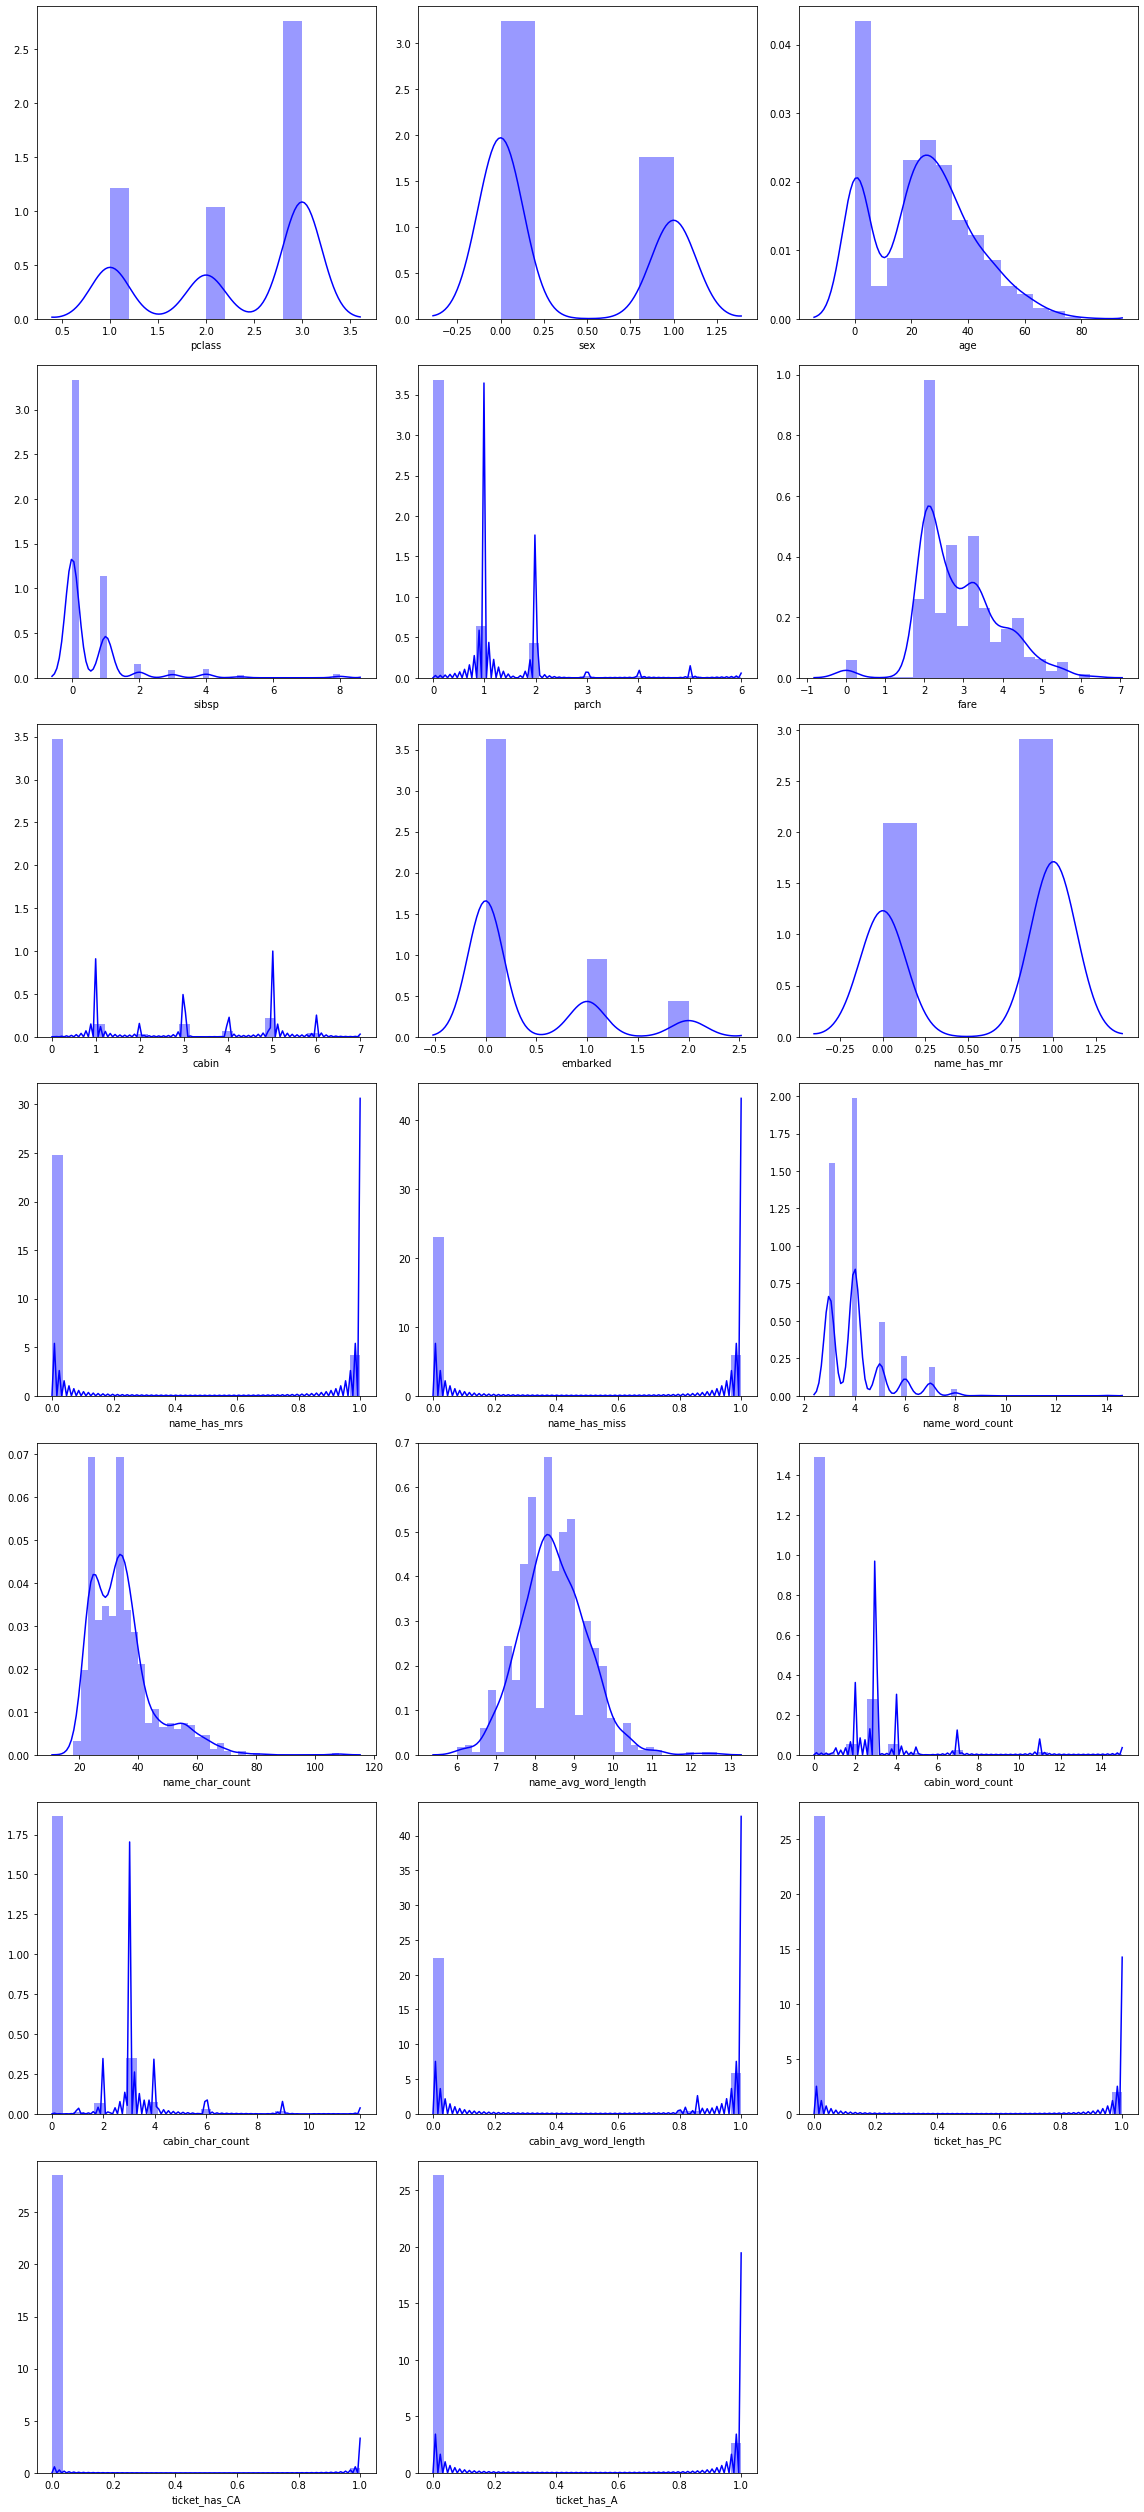

In [414]:
plot_features_dist(train, extended_feature_list)

# Save data

In [415]:
train.to_csv('data/titanic_dataset_train.csv', index=False)
test.to_csv('data/titanic_dataset_test.csv', index=False)